<a href="https://colab.research.google.com/github/shanyaanand/RecoNet/blob/master/RecoNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Upload Data

In [0]:
from google.colab import files
files.upload()

In [0]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import pandas as pd 
import numpy as np
from sklearn.metrics import recall_score
from torch.utils.data import Dataset

# Utils

In [0]:
"""
utils functions
"""
def adjust_learning_rate(optimizer, lr, lr_decay):

    for group in optimizer.param_groups:
        if 'step' not in group:
            group['step'] = 0
        group['step'] += 1

        group['lr'] = lr / (1 + group['step'] * lr_decay)


def create_optimizer(model, new_lr, opt, lr_decay, wd):
    # setup optimizer
    if opt == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=new_lr,
                              momentum=0.9, dampening=0.9,
                              weight_decay=args.wd)
    elif opt == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=new_lr,
                               weight_decay=wd)
    elif opt == 'adagrad':
        optimizer = optim.Adagrad(model.parameters(),
                                  lr=new_lr,
                                  lr_decay=lr_decay,
                                  weight_decay=wd)
    return optimizer


def Filtering(ratings, movies, threshold = 50):
    """
      Args : 
        input : rating = np array of user rating of dimension N X 4, where N is the number of users and columns are user id, movie id, star, timestamp. 
                movies = np array of user rating of dimension N X 3, where N is the number of movies and columns are movie id, movie name, movie genre
                threshold = for removing data below threshold value
        output : a list containing two np array(rating and movie)
        Ops : downsampling 
    """
    count = {} 
    for i in ratings:
        key = i[1]
        if key in count:
            count[key] +=1
        else:
            count[key] = 1

    fast = {}
    for i in movies:
        key = i[0]
        fast[key] = i

    Train_data = []
    Test_data = []
    append = {}
    genres = []
    for i in ratings:
        key = i[1]
        if count[key] > threshold:
            if key in append:
                if np.random.rand() >= 0.33:
                  Train_data.append(i)
                else:
                  Test_data.append(i)

            else:
                append[key] = 1
                Train_data.append(i)
                genres.append(fast[key])

    temp = indxing(Train_data, Test_data, genres, movie_genre)
    return temp

def indxing(Train_list, Test_list, genres_list, movie_genre):
    """
        movie id in the dataset contains gap in between, thus this function map gap id to ungap id 
    """
    feature_name = {}
    m_index = {}
    for i in range(len(genres_list)):
        m_index[genres_list[i][0]] = i + 1
        feature_name[i+1] = genres_list[i][1]
    m = i + 2
    j = 0
    for key in movie_genre:
        feature_name[m + j] =key
        j+=1
    feature_name[m+j] = 'Others'    
    train_data = []
    for i in Train_list:
        temp = i
        temp[1] = m_index[i[1]]
        train_data.append(temp)

    test_data = []
    for i in Test_list:
        temp = i
        temp[1] = m_index[i[1]]
        test_data.append(temp)

    movie = []
    for i in range(len(genres_list)):
        temp = genres_list[i]
        temp[0] = m_index[genres_list[i][0]]
        movie.append(temp) 

    return [np.array(train_data), np.array(test_data), np.array(movie), feature_name]

def R_l(W, a, l):
	if l == 0:
		return np.dot(a[0], W[0])
	else:
		eps = 1e-8
		z_k = np.dot(W[l], a[l + 1])
		s_k = np.divide(R_l(W, a, l-1), z_k)
		c_j = np.dot(s_k, W[l])
		R = np.multiply(a[l + 1], c_j)
		return R



# Data Read

In [4]:

movie_genre = {"Action" : 1, 
    "Adventure" : 2,
    "Animation" : 3,
    "Children" : 4,
    "Comedy" : 5,
    "Crime" : 6,
    "Documentary" : 7,
    "Drama" : 8,
    "Fantasy" : 9,
    "Film-Noir" : 10, 
    "Horror" : 11,
    "Musical" : 12,
    "Mystery" : 13,
    "Romance" : 14,
    "Sci-Fi" : 15,
    "Thriller" : 16,
    "War" : 17,
    "Western" : 18
  }
a = pd.read_csv("ratings.csv")
print(a.head())

   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


In [5]:
b = pd.read_csv("movies.csv")
print(b.head())

   movieId  ...                                       genres
0        1  ...  Adventure|Animation|Children|Comedy|Fantasy
1        2  ...                   Adventure|Children|Fantasy
2        3  ...                               Comedy|Romance
3        4  ...                         Comedy|Drama|Romance
4        5  ...                                       Comedy

[5 rows x 3 columns]


In [0]:
rating = np.array(a.values)
genres = np.array(b.values)
temp = Filtering(rating, genres)
TrainData, TestData, genres, feature_name = temp[0], temp[1], temp[2], temp[3]

# Model

In [0]:
class Emdedding(nn.Module):
	def __init__(self, hidden_size, input_size, output_size):
		super(Emdedding, self).__init__()
		self.lookup = nn.Linear(input_size, hidden_size,bias=False)
		self.prediction = nn.Linear(hidden_size, output_size, bias=False)
		self.relu = nn.ReLU()
		self.BN = nn.BatchNorm1d(hidden_size)
		self.Drop = nn.Dropout(0.33)
	def forward(self, x):

		# x_aux = self.Drop(self.relu(self.BN(self.lookup(x)))) # uncomment this line for incorporating BN and dropout
		x_aux = (self.lookup(x))\
			/torch.abs(x.sum(-1).view(x.size()[0], 1) + 1e-8*torch.ones([x.size()[0], 1]).cuda())
		x = (self.prediction(x_aux))
		return x, x_aux


# Dataloader

In [0]:

class dataloader(Dataset):
	
	def __init__(self, rating_list, genres_list, movie_genre, mode = "Train"):
		"""
			Args : numpy array of rating, numpy array of movies, dict. of movie genre to integer, mode of operation
		"""
		self.rating_list = rating_list
		self.genres_list = genres_list
		self.movie_genre = movie_genre
		self.length = rating_list.shape[0]
		self.n_users = len(np.unique(rating_list[:, 0]))# number of unique users
		self.n_movies = len(genres_list)# number of movies
		self.n_attr = len(movie_genre) + 1# number of features
		self.un_user = np.unique(rating_list[:, 0])

	def UserData(self, user):
		"""
			Args : user id 
			Output : input vector(as mention in the paper) of dimension = #movies * #features
		"""
		phi_v = [0]*self.n_attr# attributes feature
		Vv = [0]*self.n_movies# movies feature
		idx = np.where(self.rating_list[:, 0] == user)[0]
		movies = self.rating_list[idx, 1]# list of movies he/she rated
		stars = self.rating_list[idx, 2]
		for k in range(len(movies)):
			movie = movies[k]
			star = stars[k]
			if star >= 0.0:
				Vv[int(movie) - 1] += 1 #  movie is 1 index
			x = np.where(self.genres_list[:, 0] == movie)[0]
			strings = self.genres_list[x, 2][0].split("|")
			for string in strings:
				if string in self.movie_genre:
					phi_v[self.movie_genre[string] - 1] = 1 # movie_genre is 1 index
				else:
					phi_v[18] = 1

		return np.concatenate((Vv, phi_v), axis=0)

	def __len__(self):
		return self.length
	
	def __getitem__(self, idx):

		X = self.UserData(self.rating_list[idx, 0])
		y = [int(self.rating_list[idx, 1] - 1)]# remove the movie
		#remove features of the movie
		# w = np.where(self.genres_list[:, 0]== self.rating_list[idx, 1])[0]
		w = self.rating_list[idx, 1] - 1
		strings = self.genres_list[int(w), 2].split("|")	
		for string in strings:
			if string in self.movie_genre:
				t = self.movie_genre[string] - 20
				X[t] -= 1
			else:
				X[-1] -= 1
		X[y] = 0
		sample = {'data' : torch.Tensor(X), 'label' : torch.Tensor(y)}
		return sample


In [9]:
kwargs = {'num_workers': 8, 'pin_memory': True} 
print("number of training data {} nummber of users {} number of movies {}".format(len(TrainData), len(np.unique(TrainData[:, 0])), len(np.unique(TrainData[:, 1]))))
print("number of testing data {} nummber of users {} number of movies {}".format(len(TestData), len(np.unique(TestData[:, 0])), len(np.unique(TestData[:, 1]))))
TrainLoader = dataloader(TrainData, genres, movie_genre)
TestLoader = dataloader(TestData, genres, movie_genre) 	 	

number of training data 27376 nummber of users 606 number of movies 436
number of testing data 13284 nummber of users 597 number of movies 436


# Main

starting training!
saving
Test : epoch 0 loss 6.077684558354891 recall 0.0015808491418247517
Train : epoch 0 loss 5.2949396694932025 recall 0.05329485680888369
saving
Test : epoch 1 loss 4.19303483229417 recall 0.17660343270099368
Train : epoch 1 loss 3.3776238811350314 recall 0.30077440093512564
saving
Test : epoch 2 loss 3.41477992442938 recall 0.3243751881963264
Train : epoch 2 loss 2.3281865097651973 recall 0.4632159555815313
saving
Test : epoch 3 loss 3.437301356058854 recall 0.3696175850647395
Train : epoch 3 loss 1.8129113946005562 recall 0.5580800701344243
saving
Test : epoch 4 loss 3.842890496437366 recall 0.371875940981632
Train : epoch 4 loss 1.4629603524074377 recall 0.6320134424313267
saving
Test : epoch 5 loss 4.176113169926864 recall 0.3787262872628726
Train : epoch 5 loss 1.2140719133002735 recall 0.6925774400935125
Test : epoch 6 loss 4.685773542294135 recall 0.37563986750978623
Train : epoch 6 loss 1.0005915332063335 recall 0.7577074810052601
Test : epoch 7 loss 5.195

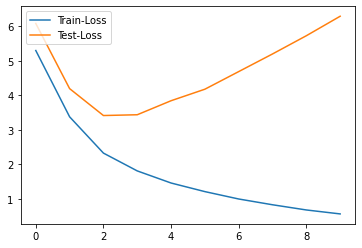

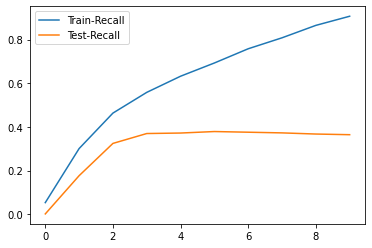

In [19]:
net = Emdedding(1024, len(genres)+len(movie_genre)+1, len(genres))
net.cuda()
batch_size = 64*4
epoch = 10
lr = 0.01
lr_decay = 0.01
wt_decay = 0.0
best_recall = 0
# optimizer = create_optimizer(net, lr, "adagrad", lr_decay, wt_decay)
optimizer = create_optimizer(net, lr, "adam", lr_decay, wt_decay)
criterion = nn.CrossEntropyLoss()
metric_test = []
metric_train = []
TrainSample = torch.utils.data.DataLoader(TrainLoader, batch_size= batch_size, shuffle=True)
TestSample = torch.utils.data.DataLoader(TestLoader, batch_size= batch_size, shuffle=False)

print("starting training!")
for n_epoch in range(epoch):
	error = 0
	labels = []
	logits = []
	count = 0
	net.eval()
	for i, batch in enumerate(TestSample):
		X = Variable(batch['data'].cuda())
		y = Variable(torch.squeeze(batch['label']).long().cuda())
		y_pred, h = net(X)
		loss = criterion(y_pred, y)
		count+=1
		error += loss.cpu().detach().numpy()
		labels += list(y.cpu().detach().numpy())
		logits += list(np.argmax(F.log_softmax(y_pred, 1).cpu().detach().numpy(), axis=1))
	recall = recall_score(labels, logits, average='micro')
	metric_test.append([n_epoch, error/count, recall])
	if recall > best_recall:
		print("saving")
		torch.save({'epoch': n_epoch + 1, 'state_dict': net.state_dict()},'model.pth')
		best_recall = recall 
	print("Test : epoch {} loss {} recall {}".format(n_epoch, error/count, recall))

	#---------------------------------------------------------------------------------------#
	error = 0
	count = 0
	labels = []
	logits = []
	net.train()
	for i, batch in enumerate(TrainSample):
		X = Variable(batch['data'].cuda())
		y = Variable(torch.squeeze(batch['label']).long().cuda())
		y_pred, h = net(X)
		optimizer.zero_grad()
		loss = criterion(y_pred, y)
		loss.backward()
		optimizer.step()
		count +=1
		error += loss.cpu().detach().numpy()
		labels += list(y.cpu().detach().numpy())
		logits += list(np.argmax(F.log_softmax(y_pred, 1).cpu().detach().numpy(), axis=1))
	adjust_learning_rate(optimizer, lr, lr_decay)
	recall = recall_score(labels, logits, average='micro')
	metric_train.append([n_epoch, error/count, recall])

	print("Train : epoch {} loss {} recall {}".format(n_epoch, error/count, recall))
metric_train = np.array(metric_train)
metric_test = np.array(metric_test)
plt.plot(metric_train[:, 0], metric_train[:, 1], label="Train-Loss")
plt.plot(metric_test[:, 0], metric_test[:, 1], label="Test-Loss")
plt.legend(loc='upper left')                
plt.show()
plt.plot(metric_train[:, 0], metric_train[:, 2], label="Train-Recall")
plt.plot(metric_test[:, 0], metric_test[:, 2], label="Test-Recall")
plt.legend(loc='upper left')                
plt.show()

# Model Relevance 

In [18]:
W = []
i = 0

for param in net.parameters():
	if i < 2:
		W.append(param.cpu().detach().numpy())
	i+=1
W = W[::-1]

for n_epoch in range(1):
	net.eval()
	for i, batch in enumerate(TestSample):
		X = Variable(batch['data']).cuda()
		y = Variable(torch.squeeze(batch['label']).long()).cuda()
		y_pred, h = net(X)
		for j in range(h.size()[0]):

			a = []
			o = np.zeros([y_pred.size()[1]])
			temp = list(np.argmax(F.log_softmax(y_pred, 1).cpu().detach().numpy(), axis=1)) 
			o[temp[j]] = 1.0
			hd = h.cpu().detach().numpy()
			ip = X.cpu().detach().numpy()
			a.append(o)
			a.append(hd[j, :])
			a.append(ip[j, :])
			rl = R_l(W, a, 1)
			pos = np.where((rl > 0))[0]
			neg = np.where((rl < 0))[0]
			print("******************************************************************************")
			print("Target movies : ", feature_name[temp[j] + 1])
			print("Positive features are ===> ")
			for p in pos:
			  print(feature_name[p + 1])
			print("Negative features are ===> ")
			for n in neg:
			  print(feature_name[n + 1])

******************************************************************************
Target movies :  Casper (1995)
Positive features are ===> 
Fargo (1996)
Indiana Jones and the Last Crusade (1989)
Grosse Pointe Blank (1997)
Run Lola Run (Lola rennt) (1998)
Comedy
Crime
Negative features are ===> 
L.A. Confidential (1997)
Being John Malkovich (1999)
Drama
Fantasy
Film-Noir
Romance
